<a href="https://colab.research.google.com/github/cvillad/covid_xray_model/blob/master/covid19_xray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Import important libraries

In [0]:
!pip install -q -U tqdm

In [0]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import shutil
import cv2

!pip install imutils

from imutils import paths
from tqdm import tqdm
import warnings

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
warnings.filterwarnings(action="ignore")

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

dataset_path = '/content/gdrive/Shared drives/Data Mining Project/dataset'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Loading the dataset

In [0]:
imagePaths = list(paths.list_images(dataset_path))

labels = []
data = []

# loop over the image paths
with tqdm(total = len(imagePaths)) as pbar:
  for imagePath in imagePaths: 
      # extract the class label from the filename
      #if imagePath.split(os.path.sep)[-2]=="pneumonia":
      # continue
      label = imagePath.split(os.path.sep)[-2]
      # load the image, swap color channels, and resize it to be a fixed
      # 224x224 pixels while ignoring aspect ratio
      image = cv2.imread(imagePath)
      image = cv2.resize(image, (224, 224))
      image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      image = image.reshape(1,-1)
      # update the data and labels lists, respectively
      data.append(image.reshape(-1))
      labels.append(label)
      pbar.update(1)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
labels = np.array(labels)
data = np.array(data)/255

100%|██████████| 426/426 [00:12<00:00, 35.18it/s]


## Transforming the labels into onehot representation

In [0]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

## Splitting the dataset (Train, Val) with a proportion 70%-30%

In [0]:
random_seed=42
from sklearn.model_selection import train_test_split

(X_train, X_val, y_train, y_val) = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=random_seed)

## Preprocess using sobel operator

In [0]:
import cv2

X_train_hist = np.zeros(shape=X_train.shape)
X_val_hist = np.zeros(shape=X_val.shape)

for i in tqdm(range(X_train.shape[0])):
    img = np.float32(X_train[i])
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)
    mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
    X_train_hist[i] = mag.reshape(-1)

for i in tqdm(range(X_val.shape[0])):
    img = np.float32(X_val[i])
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)
    mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
    X_val_hist[i] = mag.reshape(-1)

100%|██████████| 128/128 [00:00<00:00, 146.71it/s]


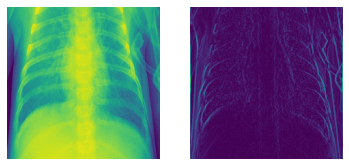

In [0]:
plt.subplot(1,2,1)
plt.imshow(X_train[1].reshape(224,224))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(X_train_hist[1].reshape(224,224))
plt.axis('off')
plt.show()

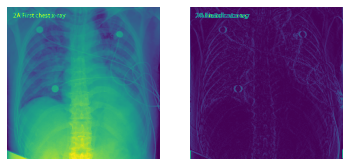

In [0]:
plt.subplot(1,2,1)
plt.imshow(X_val[1].reshape(224,224))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(X_val_hist[1].reshape(224,224))
plt.axis('off')
plt.show()

## Visualize dataset

In [0]:
# plt parameters
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [0]:
def show_random_samples_images(X, Y, samples_per_class=5, width=5, height=5):
    """
    Show some random photos of each class
    Args:
        X -- Data containg each images in the rows, [m x f], 
            m - image of flatten vector 
            f - each pixel of the image
        Y -- Labels with one hot, there are three classes
            [1,0,0] - class 0 - covid
            [0,1,0] - class 1 - normal
            [0,0,1] - class 2 - pneumonía
        samples_per_class -- Number of images we are going to plot for each class
        width -- Indicate the width of the plot
        height -- Indicate the height of the plot
    """
    # Transforms labels in a vector of 0,1,2
    plt.figure(figsize=(width, height))
    labels = np.array([one_hot_label.argmax() for one_hot_label in tqdm(Y, desc="Getting labels")]) 
    classes = ["covid", "normal", "pneumonía"]
    num_classes = len(classes)
    for y, cls in tqdm(enumerate(classes), desc="Generating plots"):
        idxs = np.flatnonzero(labels == y)
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i*num_classes+y+1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(X[idx].reshape(224,224))
            plt.axis('off')
            if i==0:
                plt.title(cls)
    plt.tight_layout()
    plt.show()

In [0]:
show_random_samples_images(X_train, y_train)

## Viewing some statistics of our dataset

In [0]:
def bar_plot_data_distribution(Y, width=10, height=10, target="train"):
    """
    Visualize the data distribution of our dataset, using bar plots
    of each class
    Args:
        Y -- Labels with one hot, there are three classes
            [1,0,0] - class 0 - covid
            [0,1,0] - class 1 - normal
            [0,0,1] - class 2 - pneumonía
        width -- Indicate the width of the plot
        height -- Indicate the height of the plot
        target -- from what distribution is Y, train or val?
    """
    sns.set(style="whitegrid")
    plt.figure(figsize=(width, height))
    labels = np.array([one_hot_label.argmax() for one_hot_label in tqdm(Y, desc="Getting labels")])
    classes = ["covid", "normal", "pneumonía"]
    distribution = [np.sum(labels == y) for y, _ in tqdm(enumerate(classes), desc="Getting Distributions")]
    sns.barplot(classes, y=distribution, orient="v", palette="Blues_d")
    plt.title("Class Distribution for each label in {0} set".format(target.upper()))
    plt.show()

In [0]:
bar_plot_data_distribution(y_train)

In [0]:
bar_plot_data_distribution(y_val, target="val")


As you can see our data have a good proportion of samples between each class

# Neural network

Initializing parameters

In [0]:
def initialize_parameters_he(layers_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the size of each layer.

    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layers_dims[1], layers_dims[0])
                    b1 -- bias vector of shape (layers_dims[1], 1)
                    ...
                    WL -- weight matrix of shape (layers_dims[L], layers_dims[L-1])
                    bL -- bias vector of shape (layers_dims[L], 1)
    """
      
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims) - 1 # integer representing the number of layers
        
    for l in range(1, L + 1):
        ### START CODE HERE ### (≈ 2 lines of code)
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(2/layers_dims[l-1])
        parameters['b' + str(l)] = np.zeros(shape = (layers_dims[l], 1))
        ### END CODE HERE ###
        
    return parameters

Test case for initialize parameters


In [0]:
layers_dims = [X_train_hist.shape[1], 200, 3]
parameters=initialize_parameters_he(layers_dims)
for param, param_value in parameters.items():
    print(param, param_value.shape)

W1 (200, 50176)
b1 (200, 1)
W2 (3, 200)
b2 (3, 1)


# Forward propagation

Sigmoid and Relu activation functions

In [0]:
def sigmoid(x):
    s = 1/(1+np.exp(-x))
    return s

def relu(x):
    s = np.maximum(0, x)
    return s

Forward for one layer

In [0]:
def activation_forward(A_prev,W,b,activation):
  """
    Arguments:
    A_prev -- numpy array containing Activation of each layer, input data in the first layer.
    W -- Weights of current layer
    b -- bias of current layer
    activation -- activation function for current layer

    Returns:
    A -- numpy array containing Activation for the next layer
    cache -- python array (list):
              linear_cache -- containing A, W, b
              activation_cache -- containing linear operation (Z)
    """
  Z = np.dot(W, A_prev) + b
  linear_cache=(A_prev,W,b)
  activation_cache = Z
  
  if activation=="relu":
    A = relu(Z)
  elif activation=="sigmoid":
    A = sigmoid(Z)

  cache=(linear_cache,activation_cache)
  return A, cache

Forward propatation 

In [0]:
def forward_propagation(X, parameters):
    #C_R = net(X.cuda()) # Using pytorch for backbone conv3d -> maxpool -> conv3d -> maxpool -> flatten
    L=len(parameters)//2 #Number of layers
    cache=[]

    #C_R_copy = C_R.clone()
    #C_R_copy = C_R_copy.detach().cpu().numpy().T
    #print("Original: ",C_R," Copy: ",C_R_copy)
    # Linear ->  Relu -> Linear -> Sigmoid
    #z1 = np.dot(W1, C_R_copy) + b1 # Using pytorch for backbone
    A=X.T
    for l in range(1,L):
      A_prev=A
      A,current_cache=activation_forward(A_prev,parameters["W"+str(l)],parameters["b"+str(l)],"relu")
      cache.append(current_cache)

    AL,current_cache=activation_forward(A,parameters["W"+str(L)],parameters["b"+str(L)],"sigmoid")
    cache.append(current_cache)
    
    return AL, cache

Test case for forward propagation

In [0]:
AL, cache = forward_propagation(X_train_hist, parameters) #forward propagation test
for param, param_value in parameters.items():
  print(param, param_value.shape)

# Backward propagation

Functions for backward

In [0]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = dZ@A_prev.T
    db = np.sum(dZ, axis = 1, keepdims=True)
    dA_prev = W.T@dZ
    
    return dA_prev, dW, db

def activation_backward(dA, cache, activation):
    linear_cache, Z = cache
    if activation == "relu":
        dZ=np.array(dA, copy=True) 
        dZ[Z <= 0] = 0
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        s = 1/(1+np.exp(-Z))
        dZ = dA * s * (1-s)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

Backward propagation

In [0]:
def backward_propagation(AL, Y, cache):
    L=len(cache)#number of layers
    m = AL.shape[1]#number of examples
    gradients={}
    #(z1, a1, W1, b1, z2, a2, W2, b2, C_R, C_R_copy) = cache
    #(z1, a1, W1, b1, z2, a2, W2, b2) = cache

    
    # dz2 = 1/m * (a2 - Y)
    # dW2 = np.dot(dz2, a1.T)
    # db2 = np.sum(dz2, axis=1, keepdims=True)

    # da1 = np.dot(W2.T, dz2)
    # dz1 = np.multiply(da1, np.int64(a1 > 0))
    # dW1 = np.dot(dz1, X)
    # #dW1 = np.dot(dz1, C_R_copy.T)
    # db1 = np.sum(dz1, axis=1, keepdims=True)
    current_cache=cache[L-1]

    dAL = 1/m * (AL - Y)
    gradients["dA"+str(L-1)], gradients["dW"+str(L)], gradients["db"+str(L)] = activation_backward(dAL, current_cache, "sigmoid")

    for l in reversed(range(1,L)):
      current_cache = cache[l-1]
      dA_prev_temp, dW_temp, db_temp = activation_backward(gradients["dA" + str(l)], current_cache, "relu")

      gradients["dA" + str(l-1)] = dA_prev_temp
      gradients["dW" + str(l)] = dW_temp
      gradients["db" + str(l)] = db_temp
    #daC = np.dot(W1.T, dz1)
    #net.zero_grad()# Clean
    #C_R.backward(torch.ones(m, 46656).cuda())
    #C_R.backward(torch.Tensor(daC).cuda())

    # gradients = {"dz2":dz2, "dW2":dW2, "db2":db2,
    #              "da1":da1, "dz1":dz1, "dW1":dW1, "db1":db1}

    return gradients

Test case for backward propagation

In [0]:
gradients = backward_propagation(AL, y_train.T, cache)
for grad_param, grad_result in gradients.items():
    print(grad_param, grad_result.shape)

# Loss function

For computing loss of the neural network

In [0]:
def compute_loss(AL, Y):
    m = Y.shape[1]
    logprobs = - np.log(AL)*Y - np.log(1-AL)*(1-Y)
    loss = 1/m * np.nansum(logprobs)
    return loss

Test case for loss

In [0]:
loss = compute_loss(AL[0:16], y_train.T[0:16])
print(round(loss,4))

2.0847


# Updating parameters

For update parameters (weights and bias) using Stochastic Gradient Descent (SGD)

In [0]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural network
    #for f in net.parameters():
     #   f.data.sub_(f.grad.data * learning_rate)

    for l in range(1,L+1):
        #print(parameters["W" + str(l)].shape,"-",grads["dW"+str(l)].shape,"l: ",l)
        parameters["W" + str(l)] -= learning_rate*grads["dW"+str(l)]
        parameters["b" + str(l)] -= learning_rate*grads["db"+str(l)]
    return parameters

Test case for update parameters

In [0]:
parameters = update_parameters(parameters, gradients, learning_rate=0.03)

# Model train

Training model using previous functions

In [0]:
def train(X, Y, learning_rate=0.1, num_iterations = 100, verbose = True, batch_size=16):
  """
    Arguments:
    X -- numpy array containing input data
    Y -- numpy array containing real predictions of data
    learning rate -- learning rate for the model
    num_iterations -- iterations for the model
    verbose -- for showing info per iterations
    batch_size -- batch size

    Returns:
    parameters -- numpy dictionary containing learned weights and bias from the data
    """
    grads = {}
    costs = []
    m = X.shape[0]

    #layers [input layer,hidden layers, output layer]
    layers_dims = [X.shape[1], 200, 200, 3]

    parameters = initialize_parameters_he(layers_dims)
    #for param, param_value in parameters.items():
     # print(param, param_value.shape)
    with tqdm(total=len(range(num_iterations))) as pbar:
        for i in range(num_iterations):
            n=len(X_train_hist)
            for index in range(0,n,batch_size):

              AL, cache = forward_propagation(X[index:index+batch_size], parameters)

              Y_batch=Y.T[index:index+batch_size]
              #print[Y_batch.shape]
              cost = compute_loss(AL, Y_batch.T)

              grads = backward_propagation(AL, Y_batch.T, cache)

              parameters = update_parameters(parameters, grads, learning_rate)
            
            if verbose:
                pbar.set_description(f"iter: {i+1}/{num_iterations}, loss:{round(cost, 10)}")

            pbar.update(1)
            costs.append(cost)
    plt.plot(costs)
    plt.ylabel("cost")
    plt.xlabel("iterations")
    plt.title("learning rate = "+ str(learning_rate))
    plt.show()

    return parameters

iter: 100/100, loss:0.2338048893: 100%|██████████| 100/100 [01:41<00:00,  1.01s/it]


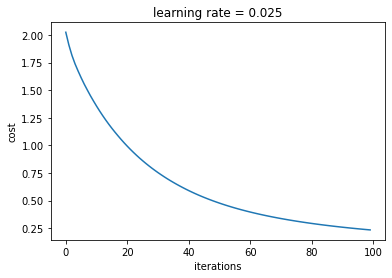

In [0]:
parameters = train(X_train_nmf, y_train.T, learning_rate=0.025, batch_size=64)

Getting the accuracy of the model

In [0]:
def accuracy(X, y, parameters):
    m = X.shape[0]
    p = np.zeros((m,), dtype=np.int)

    a2, _ = forward_propagation(X, parameters)
    labels = np.array([one_hot_label.argmax() for one_hot_label in tqdm(y.T, desc="Getting labels")]) 
    for i in range(0, a2.shape[1]):
      p[i] = a2[:,i].argmax()
    return np.mean(p == labels)

In [0]:
print(accuracy(X_val_hist, y_val.T, parameters))
print("\n",accuracy(X_train_hist, y_train.T, parameters))

Getting labels: 100%|██████████| 128/128 [00:00<00:00, 32304.65it/s]


0.8828125


Getting labels: 100%|██████████| 298/298 [00:00<00:00, 81373.87it/s]


 0.9966442953020134
